### 1. Import and Install Dependencies

! pip install tensorflow==2.18.0 opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import mediapipe as mp

### 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic Model
mp_drawing = mp.solutions.drawing_utils # Drawing Utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert color BGR to RGB
    image.flags.writeable = False                   # Image is no longer writeable
    results = model.process(image)                         # Make prediction
    image.flags.writeable = True                   # Image is writeable now
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Convert color RGB to BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)   # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)       # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)  # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80, 256, 124), thickness=1, circle_radius=1)
                             )
    
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80, 44, 124), thickness=1, circle_radius=1)
                             )
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=1, circle_radius=1)
                             )
    
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=1, circle_radius=1),
                                    mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=1, circle_radius=1)
                             )

### 3. Extract Keypoints

In [ ]:
print(len(results.pose_landmarks.landmark)) # 33
print(len(results.face_landmarks.landmark)) # 468
print(len(results.left_hand_landmarks.landmark)) # 21
print(len(results.right_hand_landmarks.landmark)) # 21

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468 * 3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21 * 3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21 * 3)
    
    return np.concatenate([pose, face, lh, rh])

In [7]:
print("Over all features:", 33 * 4 + 468 * 3 + 21 * 3 + 21 * 3)

Over all features: 1662


In [10]:
len(extract_keypoints(results))

1662

In [9]:

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read Feeds
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # print(results)
        draw_styled_landmarks(image, results)
        # draw_landmarks(image, results)
        
        
        # Show to screen
        cv2.imshow("Footage", image)

        # Break Gracefully
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
    cap.release()
    cv2.destroyAllWindows()
    

### 4. Setup Folder for collection

In [8]:
# Path for exported data, numpy arrays 
DATA_PATH = os.path.join("MP_Data")

# Actions that we try to detect 
actions = np.array(["hello", "thanks", "iloveyou"])

# Thirty Videos worth of data
no_sequences = 30

# Videos are going to 30 frames in length 
sequence_length = 30

In [9]:
# hello
## 0
## 1
## 2
## ...
## 29

# thanks

# I love you

In [10]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

### 5. Collect Keypoint Values for Training and Testing 

In [68]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # New Loop
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):


                # Read Feed
                ret, frame = cap.read()

                # Make Detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw Landmarks
                draw_styled_landmarks(image, results)

                if frame_num == 0:
                    cv2.putText(image, "STARTING COLLECTION", (120, 200),
                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15, 12),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow("OpenCV Feed", image)
                    cv2.waitKey(2000) # wait for 2 second
                else:
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                    
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break Gracefully
                if cv2.waitKey(10) & 0xFF == ord("q"):
                    break
    cap.release()
    cv2.destroyAllWindows()


### 6. Preprocess Data and Create Labels and Features

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [12]:
label_map = {label: num for num, label in enumerate(actions)}

In [13]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(label_map[action])

In [15]:
X = np.array(sequences)
y = np.array(labels)

In [16]:
X.shape

(90, 30, 1662)

In [17]:
y.shape

(90,)

In [18]:
y = to_categorical(labels).astype(int)

In [19]:
y[:2]

array([[1, 0, 0],
       [1, 0, 0]])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [21]:
y_test.shape

(5, 3)

### 7. Build and Train LSTM Neural Network

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [23]:
log_dir = os.path.join("logs")
tb_calllback = TensorBoard(log_dir=log_dir)

In [24]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

C:\Users\ADMIN\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_crossentropy'])

In [29]:
model.fit(X_train, y_train, epochs=800, callbacks=[tb_calllback])

Epoch 1/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - categorical_crossentropy: 1.0787 - loss: 1.0787
Epoch 2/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - categorical_crossentropy: 1.0537 - loss: 1.0537
Epoch 3/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - categorical_crossentropy: 1.0045 - loss: 1.0045
Epoch 4/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - categorical_crossentropy: 0.9272 - loss: 0.9272
Epoch 5/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - categorical_crossentropy: 0.8150 - loss: 0.8150
Epoch 6/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - categorical_crossentropy: 4.0742 - loss: 4.0742
Epoch 7/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - categorical_crossentropy: 1.0180 - loss: 1.0180
Epoch 8/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.1229 - loss: 1.1229
Epoch 9/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.0971 - loss: 1.0971
Epoch 10/800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_crossentropy: 1.1034 - lo

KeyboardInterrupt: 

In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │         442,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

### 8. Model Prediction

In [40]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [27]:
for i in range(5):
    print("Predicted:", actions[np.argmax(res[i])])
    print("Actual:", actions[np.argmax(y_test[i])], "\n")

Predicted: hello
Actual: iloveyou 

Predicted: hello
Actual: thanks 

Predicted: hello
Actual: thanks 

Predicted: hello
Actual: hello 

Predicted: hello
Actual: hello 



In [34]:
len(res)

5

### 9. Save Model

In [43]:
model.save("action.h5")

In [26]:
# Load model
# del model
model.load_weights('action.h5')

### 10. Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [35]:
yhat = np.argmax(model.predict(X_train), axis=1).tolist()
ytrue = np.argmax(y_train, axis=1).tolist()

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


In [36]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[57,  0],
        [16, 12]],

       [[54,  3],
        [ 0, 28]],

       [[42, 14],
        [ 1, 28]]], dtype=int64)

### 11. Test in Real Time

In [46]:
# Probability Visualization
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 80+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return output_frame

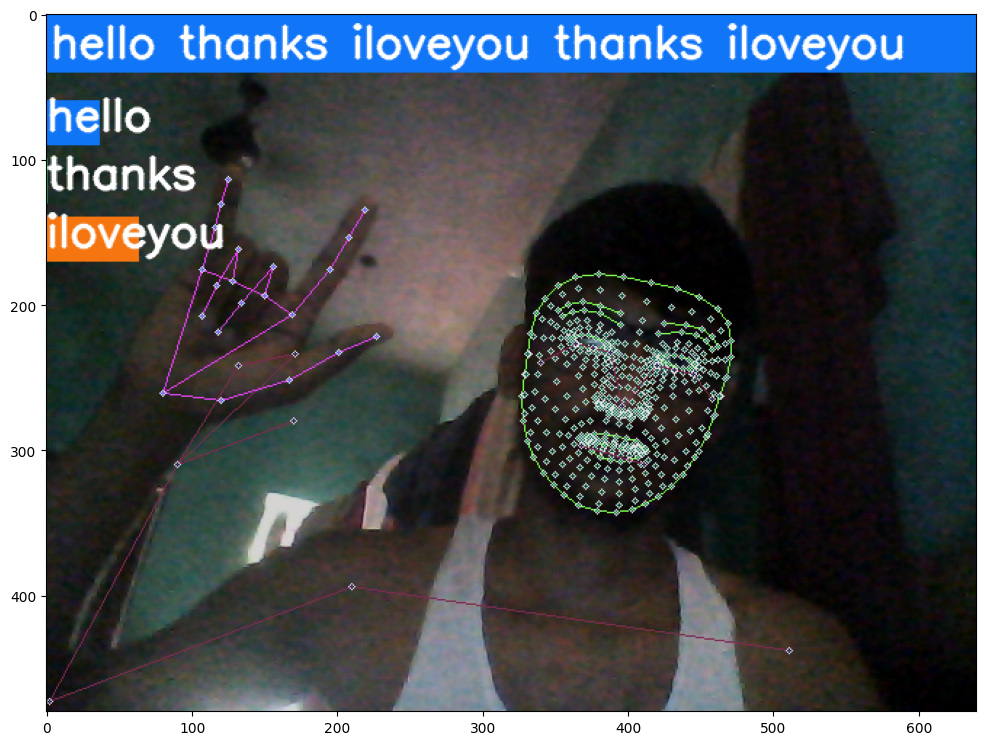

In [53]:
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(prob_viz(res, actions, image, colors), cv2.COLOR_BGR2RGB))

In [50]:
# New Detection variables 
sequence = []
sentence = []
threshold = 0.6
predictions = []

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        # print(results)

        # Draw Landmarks
        draw_styled_landmarks( image, results )

        # 2. Prediction logic 
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            # Threshold
            print(res[np.argmax(res)])

        
        # 3. Visualize Logic
            if np.unique(predictions[-10:])[0] == np.argmax(res):
                if res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0, 0), (640, 40), (247, 117, 16), -1)
        cv2.putText(image, " ".join(sentence), (3, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)


        # Show to screen
        cv2.imshow("OpenCV Feed", image)

        # Break gracefully
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
iloveyou
0.9986418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
iloveyou
0.9994973
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
iloveyou
0.9997843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
iloveyou
0.9999039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
iloveyou
0.99995816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
iloveyou
0.99998355
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
iloveyou
0.99998844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
iloveyou
0.9999937
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
iloveyou
0.99997246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
iloveyou
0.9999865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
iloveyou
0.9998605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
iloveyou
0.99933714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
iloveyou
0.9979019
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
iloveyou
0.9311215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
iloveyou
0.75960535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
iloveyou
0.5973955
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
hello
0.5562379
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 